In [99]:
import numpy
import scipy
import scipy.ndimage
import matplotlib.pyplot as plt
import queue

In [203]:
def load():
    with open("../dat/day9.txt") as f:
        for ll in f:
            depths = [ int(xx.strip()) for xx in ll.strip() ]
            yield depths

depths = numpy.array(list(load()))

In [204]:
footprint = [
    [ 0, 1, 0],
    [ 1, 1, 1],
    [ 0, 1, 0]
]

def ff(elements):
    # five elements 
    v = elements[2]
    if v < min(elements[0:2]) and v < min(elements[3:5]):
        return 1
    else:
        return 0

depth_check = scipy.ndimage.generic_filter(depths, function=ff, footprint=footprint, mode='constant', cval=10)
low_points = numpy.argwhere(depth_check == 1)

risk = 0
for xx, yy in  low_points:
    risk += (depths[xx][yy] + 1)
print(risk)


564


In [199]:
markers = numpy.zeros(depth_check.shape).astype(numpy.int16)
for ii, (xx, yy) in enumerate(low_points):
    markers[xx][yy] = ii+1
watershed = scipy.ndimage.watershed_ift(depths.astype(numpy.uint8), markers)
print(watershed)

watershed_sizes = []
for ii, (xx, yy) in enumerate(low_points):
    size = numpy.count_nonzero(watershed == ii+1)
    watershed_sizes.append((size, ii+1))

watershed_sizes.sort(reverse=True)
print(watershed_sizes[0:4])
print(watershed_sizes[0][0] * watershed_sizes[1][0] * watershed_sizes[2][0])

[[1 1 3 3 3 2 2 2 2 2]
 [1 3 3 3 3 3 2 3 2 2]
 [3 3 3 3 3 3 3 3 3 2]
 [3 3 3 3 3 3 4 3 3 3]
 [3 3 3 3 3 4 4 4 3 3]]
[(34, 3), (9, 2), (4, 4), (3, 1)]
1224


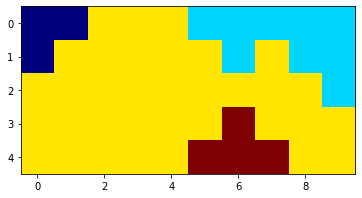

In [200]:
plt.imshow(watershed, cmap='jet') # central plot in the image above


too many values to unpack (expected 2)


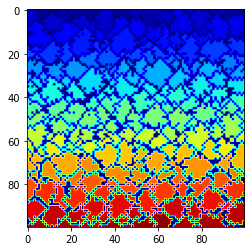

In [212]:
def neighbors(xx, yy, ww, hh):
    ans = []
    if yy > 0:
        ans.append((xx, yy-1))
    if yy < (hh - 1):
        ans.append((xx, yy+1))
    if xx > 0:
        ans.append((xx-1, yy))
    if xx < (ww - 1):
        ans.append((xx+1, yy))
    
    return ans

def do_watershed(depths, markers):
    """
    Implement Meyer's flooding algorithm
    """
    _watershed = numpy.zeros(depths.shape, dtype=numpy.int16)
    _queue = queue.Queue()

    # We know everywhere with a 9 is not a basin
    for xx, yy in numpy.argwhere(depths == 9):
        _watershed[xx][yy] = -2

    # Add all of the initial labels
    for ii, (xx, yy) in enumerate(markers):
        _watershed[xx][yy] = (ii+1)
        for _xx, _yy in neighbors(xx, yy, depths.shape[0], depths.shape[1]):
            if _watershed[_xx][_yy] == 0:
                _queue.put((_xx,_yy))
                _watershed[_xx][_yy] = -1

    while not _queue.qsize() == 0:
        xx, yy = _queue.get()

        # check neighbors label, everything should either be:
        #   unvisited = 0
        #   pending = -1
        #   wall = -2
        labels = set()
        for _xx, _yy in neighbors(xx, yy, depths.shape[0], depths.shape[1]):
            label = _watershed[_xx][_yy]
            if label not in (-2, -1, 0):
                labels.add(label)
                
        # In our case we should always have one and only one label
        if len(labels) == 1:
            label = labels.pop()
            _watershed[xx][yy] = label
        else:
            raise ValueError('input does not have isolated basins')

        # add neighbors to the queue
        for _xx, _yy in neighbors(xx, yy, depths.shape[0], depths.shape[1]):
            # non-marked neighbors not in the queue
            if _watershed[_xx][_yy] == 0:
                _queue.put((_xx,_yy, label))
                _watershed[_xx][_yy] = -1
    
    return _watershed

try:
    watershed = do_watershed(depths, low_points)
except ValueError as e:
    print(e)

plt.imshow(watershed, cmap='jet') # central plot in the image above


In [213]:
watershed_sizes = []
for ii, (xx, yy) in enumerate(low_points):
    size = numpy.count_nonzero(watershed == ii+1)
    watershed_sizes.append((size, ii+1))

watershed_sizes.sort(reverse=True)
print(watershed_sizes[0:4])
print(watershed_sizes[0][0] * watershed_sizes[1][0] * watershed_sizes[2][0])

[(105, 71), (103, 181), (96, 175), (93, 34)]
1038240
